In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

## Obtendo os dados

1. Acesse sua conta no Kaggle: https://www.kaggle.com/.
2. Clique no ícone do seu perfil no canto superior direito e selecione Account.
3. Role até a seção API e clique no botão Create New API Token.
4. Isso fará o download de um arquivo chamado kaggle.json.
5. No Google Colab, faça o upload do arquivo kaggle.json.

Utilize os seguintes comandos para habilitar as instruções do Kaggle:

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Obtendo o dataset:

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
100% 218M/218M [00:10<00:00, 24.3MB/s]
100% 218M/218M [00:10<00:00, 21.6MB/s]


Extraindo as imagens:

In [ ]:
!unzip cat-and-dog.zip -d ./PetImages

In [5]:
root = '/content/PetImages/training_set/training_set'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
category = [c.split('/')[-1] for c in categories]

print(category)

['dogs', 'cats']


In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando as imagens:

In [7]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

randomizando os dados e diminuindo o dataset devido ao limite de RAM do colab:

In [9]:
random.shuffle(data)

print("Lista original:", len(data))

data = data[:int(len(data)/2)] # pega metade da lista
print("Lista final:", len(data))

Lista original: 4002
Lista final: 2001


In [10]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [11]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0]


In [12]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(301, 2)


In [13]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 2001 images from 2 categories
train / validation / test split: 1400, 300, 301
training data shape:  (1400, 224, 224, 3)
training labels shape:  (1400, 2)


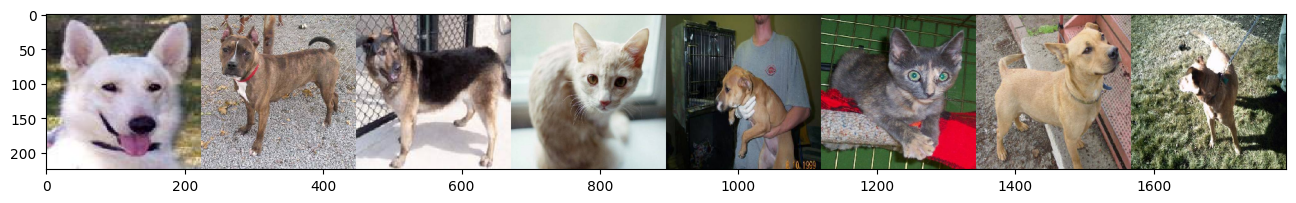

In [14]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Aplicando o Transfer Learning

In [15]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Alterando a ultima camada da rede pré-treinada para encaixar no nosso caso:

In [16]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Desabilitando o treinamento das camadas pré-treinadas, a fim de aproveitar o pré-treinamento mantendo os pesos já encontrados na mesma:

In [17]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Treinando o modelo:

In [18]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=12,
                         validation_data=(x_val, y_val))


Epoch 1/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.5182 - loss: 0.9553 - val_accuracy: 0.7433 - val_loss: 0.5755
Epoch 2/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - accuracy: 0.6414 - loss: 0.6066 - val_accuracy: 0.7633 - val_loss: 0.4812
Epoch 3/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 718ms/step - accuracy: 0.7940 - loss: 0.4769 - val_accuracy: 0.8533 - val_loss: 0.3920
Epoch 4/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step - accuracy: 0.8484 - loss: 0.3982 - val_accuracy: 0.8533 - val_loss: 0.3573
Epoch 5/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 726ms/step - accuracy: 0.8559 - loss: 0.3615 - val_accuracy: 0.8533 - val_loss: 0.3360
Epoch 6/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step - accuracy: 0.8790 - loss: 0.3375 - val_accuracy: 0.8467 - val_loss: 0.3225
Epoch 7/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 835ms/step - accuracy: 0.8600 - loss: 0.3327 - val_accuracy: 0.8733 - val_loss: 0.3000
Epoch 8/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 825ms/step - accuracy: 0.8835 - loss: 0.3070 - val_accuracy:

Vizualização dos resultados obtidos por época:

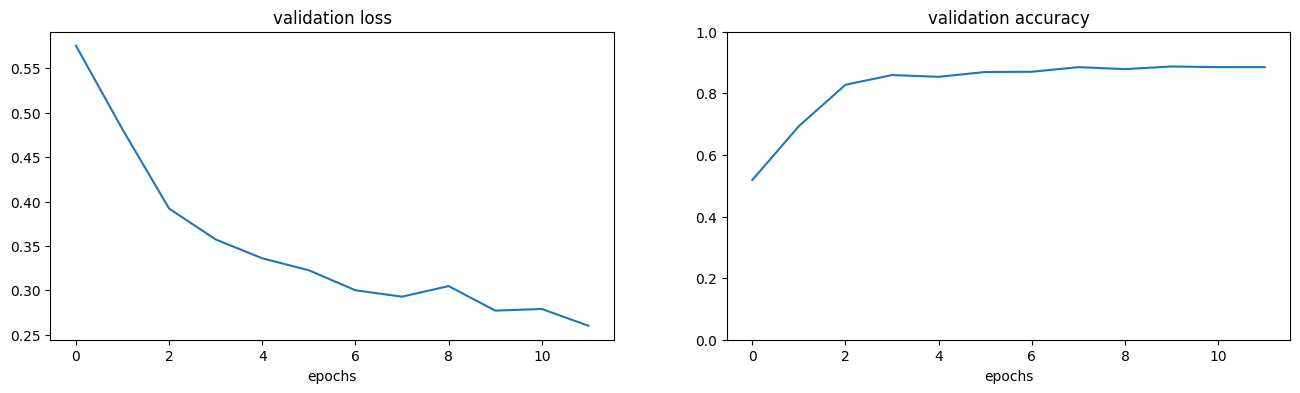

In [19]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Valores obtidos para as imagens de teste:

In [20]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.27738699316978455
Test accuracy: 0.8903654217720032


Testando para uma unica imagem:

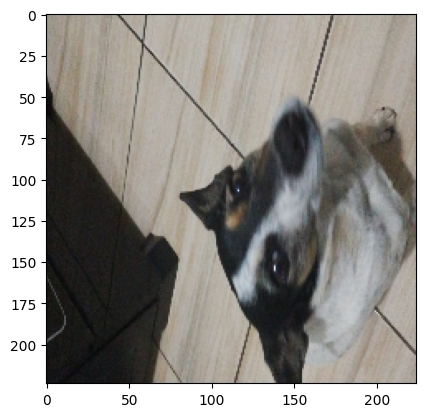

In [34]:
# foto da minha cachorrinha
img, x = get_image('/content/PXL_20240725_183315787.jpg')
plt.imshow(img)

In [35]:
probabilities = model_new.predict([x])
print(probabilities[0])
print("The animal in this image is a", categories[np.argmax(probabilities)].split('/')[-1].replace('s', '.'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[9.9959797e-01 4.0204078e-04]
The animal in this image is a dog.
